Most work in this notebook has been picked up Sudalai Rajkumar's kernels on [embeddings](https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings) and [exploration](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc). I have just tried to make them more beginner friendly. I'll be putting more detailed kernels around preprocessing on the same problem, picking up ideas from some other kernels on this problem and some of my own. 

Happy Learning!!

#### This notebook is a work in progress!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib
import cufflinks as cf
import plotly
import plotly.offline as py
import plotly.graph_objs as go
from tqdm import tqdm
tqdm.pandas()

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/test.csv


/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



# Data Wrangling and Exploration

In [2]:
!unzip ../input/quora-insincere-questions-classification/embeddings.zip

Archive:  ../input/quora-insincere-questions-classification/embeddings.zip
   creating: GoogleNews-vectors-negative300/
   creating: glove.840B.300d/
   creating: paragram_300_sl999/
   creating: wiki-news-300d-1M/
  inflating: glove.840B.300d/glove.840B.300d.txt  
  inflating: GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  
  inflating: wiki-news-300d-1M/wiki-news-300d-1M.vec  
  inflating: paragram_300_sl999/README.txt  
  inflating: paragram_300_sl999/paragram_300_sl999.txt  


In [3]:
train = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/train.csv')
test = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/test.csv')

In [4]:
print("Train set shape : ",train.shape)
print("Test set shape : ",test.shape)

Train set shape :  (1306122, 3)
Test set shape :  (375806, 2)


In [5]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [6]:
# no. of observations with distinct targets
count_targets = train['target'].value_counts()

# setting up the above results in form of a bar chart using python graph objects module
trace = go.Bar(x = count_targets.index, y = count_targets, marker = dict(color = count_targets.values))
# setting up parameters for layout of the bar chart 
layout = go.Layout(title = 'Target counts', font = dict(size=12))

data = [trace] 
fig = go.Figure(data = data, layout = layout) # inserting defined traces and layout as parameters of the plotly figure method
py.iplot(fig, filename = "TargetCount") # Plotting the bar chart


# Further, plotting the observations for each class in form of a pie chart

labels = (np.array(count_targets.index)) # defining the targets of the dataset in the labels object
# defining the proportions of count of each target out of total count
proportions = (np.array((count_targets/count_targets.sum())*100)) 

# setting up our results as parameters in the trace object i.e. the data to plot
trace = go.Pie(labels = labels, values = proportions)
layout = go.Layout(                       
    title = "Target proportion pie",     # pie chart layout specifications 
    font = dict(size = 12),
    width = 600,
    height = 600)

data = [trace]
fig = go.Figure(data = data, layout = layout) 
py.iplot(fig, filename = "usertype")  # Plotting the pie chart

Our dataset is highly imbalanced.

In [7]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [8]:
# Number of words in sentences of the text 
train['num_words'] = train['question_text'].apply(lambda x: len(str(x).split()))
test['num_words'] = test['question_text'].apply(lambda x: len(str(x).split()))

In [9]:
maximum,mean = train['num_words'].max(),train['num_words'].mean()

In [10]:
print("Maximum no. of words : ",maximum)
print("Average no. of words : {:.2f}".format(mean))

Maximum no. of words :  134
Average no. of words : 12.80


In [11]:
train['num_words'].quantile([0.25,0.5,0.75,0.99])

0.25     8.0
0.50    11.0
0.75    15.0
0.99    39.0
Name: num_words, dtype: float64

In [12]:
# Number of unique words in sentences of the text 
train['num_unique_words'] = train['question_text'].apply(lambda x: len(set(str(x).split()))) #set only holds unique
test['num_unique_words'] = test['question_text'].apply(lambda x: len(set(str(x).split())))   # values

In [13]:
maximum_unique,mean_unique = train['num_unique_words'].max(),train['num_unique_words'].mean()

In [14]:
print("Maximum no. of words : ",maximum_unique)
print("Average no. of words : {:.2f}".format(mean_unique))

Maximum no. of words :  96
Average no. of words : 12.14


In [15]:
train['num_unique_words'].quantile([0.25,0.5,0.75,0.99])

0.25     8.0
0.50    11.0
0.75    15.0
0.99    34.0
Name: num_unique_words, dtype: float64

In [16]:
#Truncating the no. of words since that large a number is very rare in the dataset
train['num_words'].loc[train['num_words']>50] = 50 
train['num_unique_words'].loc[train['num_unique_words']>50] = 50

Text(0.5, 1.0, 'Number of unique words in each class')

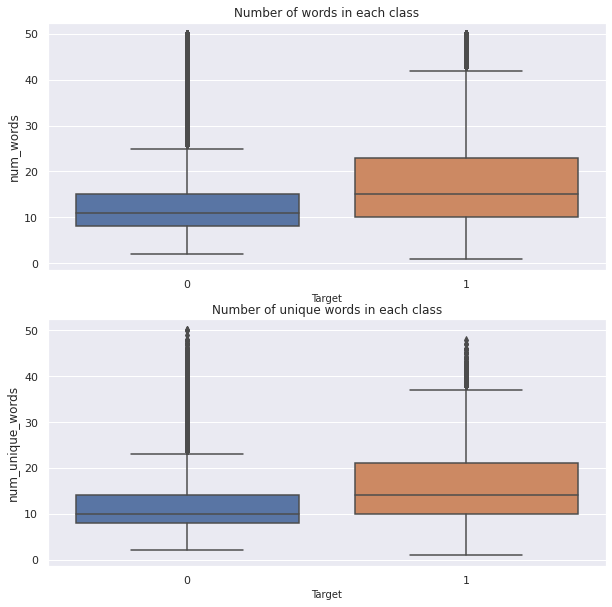

In [17]:
f,axes = plt.subplots(2,1,figsize = (10,10))

sns.boxplot(x = 'target', y = 'num_words', data = train, ax = axes[0])
axes[0].set_xlabel('Target', fontsize = 10)
axes[0].set_title('Number of words in each class', fontsize = 12)

sns.boxplot(x = 'target', y = 'num_unique_words', data = train, ax = axes[1])
axes[1].set_xlabel('Target', fontsize = 10)
axes[1].set_title('Number of unique words in each class', fontsize = 12)


Ideas around Visualization using plotly have been taken from this amazing [kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) by Sudalai Rajakumar(@srk)

# Model Building

In [18]:
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Dense, Activation, GRU, Conv1D, Activation, Dropout, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [19]:
# 85-15 train, validation split
train_df, val_df = train_test_split(train, test_size=0.15, random_state=1000)

In [20]:
# size of every word vector
embed_size = 300

# number of unique words to use 
max_features = 50000

# maximum number of words in a question. This will be our input size
maxlen = 100

In [21]:
# Filling missing values in the text columns if any
train_X = train_df['question_text'].fillna("_na_").values
val_X = val_df['question_text'].fillna("_na_").values
test_X = test['question_text'].fillna("_na_").values

In [22]:
# Tokenizing words in our sentences using keras tokenizer
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(train_X))

In [23]:
# converting each text in the dataset to a sequence of integers
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

In [24]:
# Padding sequences 
# Rememeber : The maximum length of our input can not be greater than 100 so we need to pad the incoming sequences at 100

train_X = pad_sequences(train_X, maxlen = maxlen)
val_X = pad_sequences(val_X, maxlen = maxlen)
test_X = pad_sequences(test_X, maxlen = maxlen)

In [25]:
#Target values
train_y = train_df['target'].values
val_y = val_df['target'].values

### GloVe 

In [26]:
embeddings = 'glove.840B.300d/glove.840B.300d.txt'

def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype = 'float32')

In [27]:
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(embeddings))

In [28]:
embs = np.stack(embeddings_index.values())
embs_mean,embs_std = embs.mean(),embs.std()
embs_shape = embs.shape[1]

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [29]:
word_index = tokenizer.word_index #dictionary of tokens of words in our input text
nb_words = min(max_features,len(word_index)) #number of words
embedding_matrix = np.random.normal(embs_mean, embs_std, (nb_words,embed_size)) #emedding matrix of shape(50000,300)

In [30]:
for word,i in word_index.items():
    if i >= max_features:
        continue
        embeddings_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embeddings_vector

### Building the Network

In [31]:
inp = Input(shape = (maxlen,)) #input layer
x = Embedding(max_features,embed_size,weights = [embedding_matrix])(inp) #embedding layer
x = Bidirectional(GRU(64, return_sequences = True))(x) #bidirectional GRU layer
x = GlobalMaxPool1D()(x) #layer that yields the maximum input as the output 
x = Dense(16, activation = 'relu')(x) #dense layer with relu activation
x = Dropout(0.1)(x)
x = Dense(1, activation = 'sigmoid')(x) #dense layer with sigmoid activation
model = Model(inputs = inp, outputs = x)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

Details on the binary cross entropy and thresholds in this [paper](https://arxiv.org/abs/1402.1892).

In [32]:
# Training the model in batch sizes of 1024 for 5 iterations
model.fit(train_X, train_y, batch_size=1024, epochs=5, validation_data=(val_X, val_y))

Epoch 1/5
1085/1085 [==============================] - 370s 341ms/step - loss: 0.1322 - accuracy: 0.9505 - val_loss: 0.1114 - val_accuracy: 0.9557
Epoch 2/5
1085/1085 [==============================] - 365s 336ms/step - loss: 0.1038 - accuracy: 0.9586 - val_loss: 0.1076 - val_accuracy: 0.9571
Epoch 3/5
1085/1085 [==============================] - 364s 336ms/step - loss: 0.0938 - accuracy: 0.9623 - val_loss: 0.1103 - val_accuracy: 0.9571
Epoch 4/5
1085/1085 [==============================] - 365s 336ms/step - loss: 0.0832 - accuracy: 0.9666 - val_loss: 0.1108 - val_accuracy: 0.9562
Epoch 5/5
1085/1085 [==============================] - 372s 343ms/step - loss: 0.0702 - accuracy: 0.9721 - val_loss: 0.1232 - val_accuracy: 0.9560


In [33]:
pred_glove_val_y = model.predict([val_X], batch_size=1024, verbose=1)
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))))

192/192 [==============================] - 7s 39ms/step
F1 score at threshold 0.1 is 0.6056338028169015
F1 score at threshold 0.11 is 0.6105462582886012
F1 score at threshold 0.12 is 0.6144968422402461
F1 score at threshold 0.13 is 0.6185607294041029
F1 score at threshold 0.14 is 0.6216091347105801
F1 score at threshold 0.15 is 0.6229157616867711
F1 score at threshold 0.16 is 0.6252492817306068
F1 score at threshold 0.17 is 0.6262785208497247
F1 score at threshold 0.18 is 0.6281763180639586
F1 score at threshold 0.19 is 0.6311449634883478
F1 score at threshold 0.2 is 0.6327049353950435
F1 score at threshold 0.21 is 0.6333190822288728
F1 score at threshold 0.22 is 0.6352848101265822
F1 score at threshold 0.23 is 0.6363999274178915
F1 score at threshold 0.24 is 0.6375728262064416
F1 score at threshold 0.25 is 0.6375933180575061
F1 score at threshold 0.26 is 0.6388382051759448
F1 score at threshold 0.27 is 0.639702847709451
F1 score at threshold 0.28 is 0.6404575237662388
F1 score at thre

In [34]:
pred_glove_test_y = model.predict([test_X], batch_size=1024, verbose=1)

367/367 [==============================] - 15s 40ms/step
